In [1]:
using DrWatson
@quickactivate "haram"

In [2]:
using main
using Plots, Random, Distributions, ProgressMeter
using Flux, DynamicPPL, Zygote

gr()
theme(:default)
default(fmt=:png, levels=7, lw=0.5, msw=0.5, la=0.5)
ProgressMeter.ijulia_behavior(:clear);

In [3]:
function plot_colorbar(cls)
    scatter([0, 0], [0, 1],
        zcolor=[0, 1], clims=(0, 1), xlims=(1, 1.1), c=cls,
        label="", colorbar_title="", framestyle=:none
    )
end

function nn_plot(theta; res=25, c=:viridis)
    x_range = collect(range(-6; stop=6, length=res))
    contourf(
        x_range, x_range,
        (x, y) -> f(theta)([x, y])[1], c=c
    )
    scatter!(
        Tuple.(eachrow(xs)),
        c=map(x -> x == 1 ? :firebrick1 : :dodgerblue1, ys),
        m=map(x -> x == 1 ? :square : :circle, ys),
        group=ys,
        legend=:bottomright
    )
end

function nn_plot_mean(thetas; c=:viridis, res=25)
    x_range = collect(range(-6; stop=6, length=res))
    contourf(
        x_range, x_range,
        (x, y) -> mean([f(theta)([x, y])[1] for theta in eachrow(thetas)]), c=c
    )
    scatter!(
        Tuple.(eachrow(xs)),
        c=map(x -> x == 1 ? :firebrick1 : :dodgerblue1, ys),
        m=map(x -> x == 1 ? :square : :circle, ys),
        group=ys,
        legend=:bottomright
    )
end

function make_model(ξ::DynamicPPL.Model, d)
    U(x) = min(-logjoint(ξ, (; θ=x)), floatmax(Float64))
    dU(x) = Zygote.gradient(x_ -> Zygote.forwarddiff(U, x_), x)[1]
    f(x) = max(exp(-U(x)), floatmin(Float64))
    g(x) = Zygote.gradient(x_ -> Zygote.forwarddiff(f, x_), x)
    return main.Model(ξ=ξ, d=d, f=f, g=g, U=U, dU=dU)
end

make_model (generic function with 1 method)

In [4]:
Random.seed!(2022)
s = 1.25
μ = [[1.0 1.0], [-1.0 -1.0], [1.0 -1.0], [-1.0 1.0],] .* 2
x0 = [s .* randn(30, 2) .+ μ[1]; s .* randn(100, 2) .+ μ[2]]
x1 = [s .* randn(10, 2) .+ μ[3]; s .* randn(80, 2) .+ μ[4]]
xs = [x0; x1]
ys = [zeros(size(x0, 1)); ones(size(x1, 1))] .|> Int;

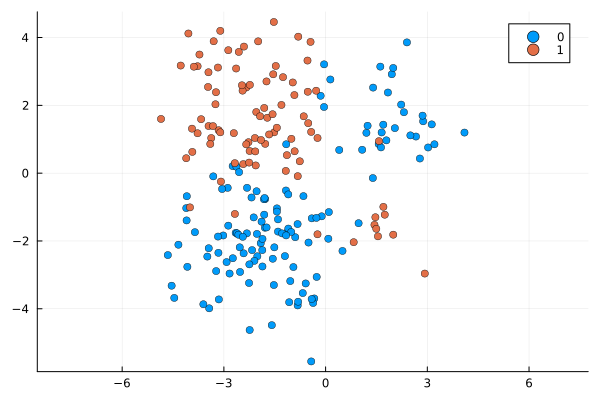

In [5]:
scatter(Tuple.(eachrow(xs)), group=ys, ratio=1)

In [6]:
F = Chain(
    Dense(2, 2, tanh),
    Dense(2, 2, tanh),
    Dense(2, 1, sigmoid)
)

θ, f = Flux.destructure(F)
sigma = sqrt(1.0 / 0.09)

@model function bayes_nn(xs, ys, nθ, f)
    θ ~ MvNormal(zeros(nθ), sigma .* ones(nθ))
    F = f(θ)
    ps = F(xs)
    for i in eachindex(ys)
        ys[i] ~ Bernoulli(ps[i])
    end
end;

ξ = bayes_nn(xs', ys, length(θ), f)
model = make_model(ξ, length(θ));

In [7]:
s1, a1 = mcmc(
    DualAverage(λ=1, δ=0.7),
    HMC(),
    model; n=2e3, n_burn=5e2
)
x_hmc = s1[a1, :];

Progress: 100%|█████████████████████████████████████████| Time: 0:01:37
  HMC:  0.5717141429285357


Acceptance Ratio = 0.5679


In [8]:
s2, a2 = mcmc(
    DualAverage(λ=0.5, δ=0.7),
    HaRAM(),
    model; n=2e3, n_burn=5e2
)
x_haram = s2[a2, :];

Progress: 100%|█████████████████████████████████████████| Time: 0:02:12
  HaRAM:  0.8225887056471765


Acceptance Ratio = 0.8189


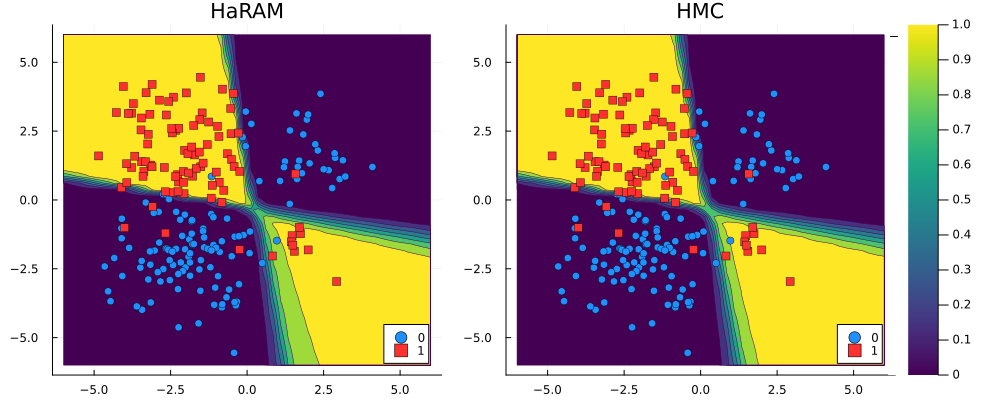

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [9]:
st, res = 2, 50
cls = palette(:viridis, rev=false)

plot(
    plot(
        nn_plot_mean(x_haram[1:st:end, :], res=res, c=cls),
        colorbar=false, title="HaRAM",
    ),
    plot(
        nn_plot_mean(x_hmc[1:st:end, :], res=res, c=cls),
        colorbar=false, title="HMC",
    ),
    plot_colorbar(cls),
    layout=(@layout [grid(1, 2) a{0.035w}]),
    link=:all,
    size=(1000, 400)
)